In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
PATH_TR = 'drive/My Drive/NER/uebung6.train'

In [3]:
import numpy as np
import pandas as pd
import re
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
with open(PATH_TR, 'r') as f:
    lines = f.readlines()
    
lines = [line.strip() for line in lines]
token = ['<START>' if str.split(line, ' ')[0] == '' else str.split(line, ' ')[0] for line in lines]
tag = ['<START>' if str.split(line, ' ')[0] == '' else str.split(line, ' ')[1] for line in lines]
label = ['<START>' if str.split(line, ' ')[0] == '' else str.split(line, ' ')[2] for line in lines]

In [0]:
def to_str_token(token, word = True):
  token_seq = " ".join(token)
  
  if(word):
    token_seq = re.sub('-DOCSTART- <START>', '',token_seq)
    
  
  else:
    token_seq = re.sub('X <START>', '',token_seq)
  
  sentence_tok = token_seq.split("<START>")
  sentence_tok = [s.strip() for s in sentence_tok]
  sentence_tok = [s.split(' ') for s in sentence_tok]
  sentence_list =  [list(filter(None, s)) for s in sentence_tok]
  sentence_list = list(filter(None, sentence_tok))
  
  return(sentence_tok)

In [6]:
sent_tok = to_str_token(token)[:-1]
sent_tag = to_str_token(tag, False)[:-1]
sent_lab = to_str_token(label, False)[:-1]


len(sent_tok), len(sent_tag), len(sent_lab)

(12000, 12000, 12000)

In [76]:
sent_tok

[['Phenotypic',
  'analysis',
  'demonstrates',
  'that',
  'trio',
  'and',
  'Abl',
  'cooperate',
  'in',
  'regulating',
  'axon',
  'outgrowth',
  'in',
  'the',
  'embryonic',
  'central',
  'nervous',
  'system',
  '(',
  'CNS',
  ')',
  '.'],
 ['We',
  'measured',
  'electromyograms',
  '(',
  'EMG)',
  'of',
  'the',
  'alae',
  'nasi',
  'to',
  'determine',
  'the',
  'relationship',
  'between',
  'their',
  'activity',
  'and',
  'timing',
  'to',
  'contraction',
  'of',
  'the',
  'rib',
  'cage',
  'muscles',
  'and',
  'diaphragm',
  'during',
  'obstructive',
  'apnea',
  'in',
  'nine',
  'patients',
  '.'],
 ['However',
  'the',
  'precise',
  'function',
  'of',
  'DNA-PK',
  'in',
  'DNA',
  'double-strand',
  'break',
  'repair',
  'is',
  'not',
  'known',
  '.'],
 ['The',
  'COR',
  'biosynthetic',
  'gene',
  'cluster',
  'in',
  'P.',
  'syringae',
  'pv.',
  'glycinea',
  'PG4180',
  'is',
  'encoded',
  'by',
  'a',
  '32-kb',
  'region',
  'which',
  'cont

In [7]:
np.concatenate(sent_tok).shape

(305215,)

In [8]:
sen_lengts = [len(s) for s in sent_tok]
SEQ_LEN = 40
np.mean(sen_lengts), np.max(sen_lengts)


(25.434583333333332, 198)

In [0]:
def cut_seq(sequences, SEQ_LEN):
  seqs_cut = []

  for seq in sequences:
    seq_cut = [seq[i:i+SEQ_LEN]  for i in range(0,len(seq), SEQ_LEN)]
    seqs_cut.extend(seq_cut)
    
  return(seqs_cut)

In [0]:
tok_cut = cut_seq(sent_tok, SEQ_LEN)
tag_cut = cut_seq(sent_tag, SEQ_LEN)
lab_cut = cut_seq(sent_lab, SEQ_LEN)

In [0]:
MAX_VOCAB = 10000

tokenizer_word = Tokenizer(num_words = MAX_VOCAB, oov_token = "<UNK>")
tokenizer_word.fit_on_texts(sent_tok)

word_seqs = tokenizer_word.texts_to_sequences(sent_tok)

In [12]:
np.concatenate(word_seqs).shape

(305215,)

In [17]:
(np.concatenate(word_seqs)== 0).sum()

0

In [51]:
X[0][:19]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 2953], dtype=int32)

In [48]:
40 - 22

18

In [0]:
X = sequence.pad_sequences(word_seqs, maxlen = SEQ_LEN)


In [56]:
np.concatenate(word_seqs).shape[0] - np.concatenate(X).shape[0]

-174785

In [69]:
sum(np.concatenate(word_seqs) == 0), sum(np.concatenate(X) == 0),  len(np.concatenate(X) == 0)

(0, 190994, 480000)

In [65]:
12000 * 40 - 12000 * np.mean(sen_lengts)

174785.0

In [0]:
label_to_idx  = {label:c+1 for c, label in enumerate(set(np.concatenate(sent_lab)))}
idx_to_label =  {c+1:label for c, label in enumerate(set(np.concatenate(sent_lab)))}
label_to_idx['PAD'] = 0
idx_to_label[0] = 'PAD'
idx_seqs = [[label_to_idx[label] for label in seq]  for seq in  sent_lab]
y = sequence.pad_sequences(idx_seqs, maxlen = SEQ_LEN)


In [24]:
np.concatenate(y).shape[0] - np.concatenate(idx_seqs).shape[0]

174785

In [0]:
y = to_categorical(y)

In [0]:
# source https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding,Bidirectional,GRU, TimeDistributed, Dropout


#construct model
embedding_size= 100
h_size = 32 

model=Sequential()
model.add(Embedding(MAX_VOCAB, embedding_size, input_length=SEQ_LEN, mask_zero = True))
model.add(Bidirectional(GRU(h_size, input_shape = (SEQ_LEN,embedding_size), return_sequences=True)))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(Dense(4, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 100)           1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40, 64)            25536     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 40, 64)            0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 40, 4)             260       
Total params: 1,025,796
Trainable params: 1,025,796
Non-trainable params: 0
_________________________________________________________________


In [31]:
#train model for one epoch
batch_size = 228
epochs = 10
hist = model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split= 0.3)

Train on 8400 samples, validate on 3600 samples
Epoch 1/10
8400/8400 [==============================] - 9s 1ms/step - loss: 0.8298 - f1: 0.2849 - val_loss: 0.4823 - val_f1: 0.5566
Epoch 2/10
8400/8400 [==============================] - 8s 927us/step - loss: 0.3058 - f1: 0.5490 - val_loss: 0.3109 - val_f1: 0.5623
Epoch 3/10
8400/8400 [==============================] - 8s 929us/step - loss: 0.2172 - f1: 0.5531 - val_loss: 0.2476 - val_f1: 0.5664
Epoch 4/10
8400/8400 [==============================] - 8s 943us/step - loss: 0.1750 - f1: 0.5574 - val_loss: 0.2207 - val_f1: 0.5719
Epoch 5/10
8400/8400 [==============================] - 8s 939us/step - loss: 0.1488 - f1: 0.5647 - val_loss: 0.2016 - val_f1: 0.5798
Epoch 6/10
8400/8400 [==============================] - 8s 925us/step - loss: 0.1288 - f1: 0.5707 - val_loss: 0.1860 - val_f1: 0.5849
Epoch 7/10
8400/8400 [==============================] - 8s 914us/step - loss: 0.1122 - f1: 0.5740 - val_loss: 0.1794 - val_f1: 0.5855
Epoch 8/10
8400/

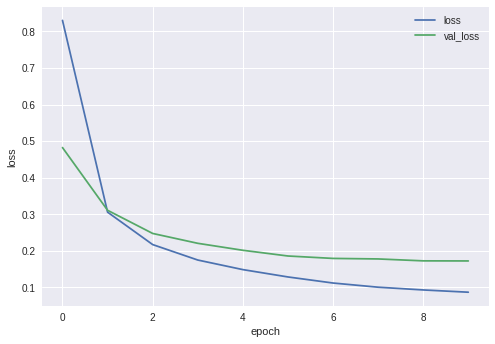

In [32]:
# plot MAE over epochs for different models
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
#axes = plt.gca()
#axes.set_ylim([4,20])
plt.rcParams["figure.figsize"] = (8, 6) # (w, h)

plt.legend(['loss', 'val_loss'], loc='upper right')
plt.plot()
plt.show()

In [0]:
preds = model.predict(X)
preds = np.argmax(preds, axis = -1)

In [70]:
preds.shape

(12000, 40)

In [75]:
preds[1], X[1]

(array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([   0,    0,    0,    0,    0,    0,   27,  211,    1,   11,    1,
           3,    2,    1,    1,    9,  478,    2,  655,   60,  125,   39,
           6, 3216,    9, 2732,    3,    2,    1, 5326, 1499,    6, 3980,
          69, 3981, 4562,    7, 1009,   32,    5], dtype=int32))

In [0]:
preds_long = preds.flatten()
X_long = X.flatten()

In [38]:
X_long.shape, preds_long.shape

((480000,), (480000,))

In [0]:
pad_idx = X_long == 0

In [55]:
(X == 0).sum()

190994

In [43]:
sum(pad_idx)

190994

In [0]:
X_long = X.flatten()
pad_idx = X_long != 0

In [0]:
labels_preds = np.array([idx_to_label[y] for y in preds_long])

In [0]:
labels_preds = labels_preds[pad_idx]

In [0]:
labels_preds.shape, np.concatenate(sent_lab).shape

((289006,), (305215,))

In [0]:
df_res = pd.DataFrame([labels_preds,np.concatenate(sent_lab)]).T

In [0]:
df_res = df_res.T

In [0]:
df_res.head()

,0,1
0,O,O
1,O,O
2,O,O
3,O,O
4,B-NP,B-NP


In [0]:
output_lines = []
j = 0 


for i in range(len(token)):
  if token[i] == '-DOCSTART-':
    output_lines.append('-DOCSTART- X X O')
  elif token[i] == '<START>':
    output_lines.append('')
  else:
    txt = token[i] + " " + tag[i] + " " + labels_preds[j]
    j += 1
    output_lines.append(txt)    

In [0]:
label_pred = [tokenizer_label.index_word[i] for i in f]

In [0]:
PATH_VAL = "drive/My Drive/NER/uebung6.val"

with open(PATH_VAL, 'r') as f:
    lines = f.readlines()
    
lines = [line.strip() for line in lines]
token = ['<START>' if str.split(line, ' ')[0] == '' else str.split(line, ' ')[0] for line in lines]
tag = ['<START>' if str.split(line, ' ')[0] == '' else str.split(line, ' ')[1] for line in lines]
label = ['<START>' if str.split(line, ' ')[0] == '' else str.split(line, ' ')[2] for line in lines]

sent_tok = to_str_token(token)[:-1]
sent_tag = to_str_token(tag, False)[:-1]
sent_lab = to_str_token(label, False)[:-1]

tok_cut = cut_seq(sent_tok, SEQ_LEN)
tag_cut = cut_seq(sent_tag, SEQ_LEN)
lab_cut = cut_seq(sent_lab, SEQ_LEN)

word_seqs = tokenizer_word.texts_to_sequences(sent_tok)
X_val = sequence.pad_sequences(word_seqs, maxlen = SEQ_LEN)

len(sent_tok), len(sent_tag), len(sent_lab)


(2000, 2000, 2000)

In [0]:
idx_seqs = [[label_to_idx[label] for label in seq]  for seq in  sent_lab]
y_val = sequence.pad_sequences(idx_seqs, maxlen = SEQ_LEN)
y_val = to_categorical(y)

In [0]:
preds = model.predict(X_val)

In [0]:
preds = np.argmax(preds, axis=-1)
preds = preds.flatten()
labels_preds = np.array([idx_to_label[y] for y in preds])

pad_idx = X_val.flatten() != 0
labels_preds = labels_preds[pad_idx]
df_res = pd.DataFrame([labels_preds,np.concatenate(sent_lab)]).T

In [0]:
labels_preds.shape, np.concatenate(sent_lab).shape

((47767,), (50246,))

In [0]:
np.concatenate(sent_lab).shape

(305215,)

In [0]:
df_res.head(),df_res.tail()

(      0     1
 0     O     O
 1     O     O
 2     O     O
 3     O     O
 4  B-NP  B-NP,            0  1
 305210  None  O
 305211  None  O
 305212  None  O
 305213  None  O
 305214  None  O)

In [0]:
label_to_idx

{'B-NP': 1, 'I-NP': 2, 'O': 3, 'PAD': 0}

In [0]:
def get_F1(df):
    #df = dataframe with label and preds = prediction column
    #returns F1, precision, recall
    TN1 = (df.loc[df.label != 'O'].preds.values == 'O').sum()
    FP1 = (df.loc[df.label == 'O'].preds.values == 'B-NP').sum()

    TP1 = (df.loc[df.label == 'B-protein'].preds.values == 'B-protein').sum()
    FN1 = (df.loc[df.label == 'B-protein'].preds.values == 'O').sum()


    precision1 = TP1 / (TP1 + FP1)
    recall1 = TP1 / (TP1 + FN1)

    I_F1 = 2 * precision1 * recall1 / (precision1 + recall1)
    
    ###
    FP2 = (df.loc[df.label == 'O'].preds.values == 'I-NP').sum()

    
    
    
    
    
    return(F1,precision,recall)

,0,1
0,O,O
1,O,O
2,O,O
3,O,O
4,B-NP,B-NP
5,O,O
6,B-NP,B-NP
7,O,O
8,O,O
9,O,O


# pandas df

In [0]:
df_full = pd.read_table(PATH_TR, sep = ' ', names= ['token', 'POS','label'],skip_blank_lines=False, index_col = False)



In [0]:
t = set(df.token.values)

In [0]:
'-START-' in t

False

In [0]:
idx_nan = df_full.loc[df.isnull().any(axis=1)].index
idx_doc_start = df_full.loc[df.token == '-DOCSTART-'].index

In [0]:
df = df.loc[df.token != '-DOCSTART-']

In [0]:
df = df.fillna('<SPLIT>')

In [0]:
values = df.token.values

In [0]:
full_seq = ' '.join(values[:-1] )#values finish with split 
full_seq = re.sub(pattern = ' <SPLIT> <SPLIT>', repl = '<SPLIT> ', string = full_seq)
sentence_list = full_seq.split('<SPLIT> ')

In [0]:
sentence_list = list(filter(None, sentence_list))

In [0]:
len(sentence_list)

12018

In [0]:
full_seq[:1000]

'<SPLIT> Phenotypic analysis demonstrates that trio and Abl cooperate in regulating axon outgrowth in the embryonic central nervous system ( CNS ) .<SPLIT>  We measured electromyograms ( EMG) of the alae nasi to determine the relationship between their activity and timing to contraction of the rib cage muscles and diaphragm during obstructive apnea in nine patients .<SPLIT>  However the precise function of DNA-PK in DNA double-strand break repair is not known .<SPLIT>  The COR biosynthetic gene cluster in P. syringae pv. glycinea PG4180 is encoded by a 32-kb region which contains both the structural and regulatory genes needed for COR synthesis .<SPLIT>  FEurea was also measured during stable graft function , 7-14 days prior to allograft dysfunction .<SPLIT>  On the other hand hypokalemia , induced by diuretics , may also be accompanied by a significant depletion of total body K , bringing about more general consequences .<SPLIT>  We present here the complete primary structure of human

In [0]:
  full_seq = ' '.join(values[:-1] )#values finish with split 
  full_seq = re.sub(pattern = ' <SPLIT> <SPLIT>', repl = '<SPLIT> ', string = full_seq)
  sentence_list = full_seq.split('<SPLIT> ')
  sentence_list  = [s[1:].split(' ') for s in sentence_list]
  sentence_list =  [list(filter(None, s)) for s in  sentence_list]
  sentence_list = list(filter(None, sentence_list))

In [0]:
def col_to_seq(values):
  full_seq = ' '.join(values[:-1] )#values finish with split 
  full_seq = re.sub(pattern = ' <SPLIT> <SPLIT>', repl = '<SPLIT> ', string = full_seq)
  sentence_list = full_seq.split('<SPLIT> ')
  sentence_list  = [s[1:].split(' ') for s in sentence_list]
  sentence_list =  [list(filter(None, s)) for s in  sentence_list]
  sentence_list = list(filter(None, sentence_list))
  return(sentence_list)

In [0]:
token_seq = col_to_seq(df.token.values)

In [0]:
MAX_LEN = np.max([len(s) for s in sentence_list])
AVG_LEN = np.mean([len(s) for s in sentence_list])
MAX_LEN, AVG_LEN

(198, 25.416874687968047)

In [0]:
SEQ_LEN = MAX

In [0]:
MAX_VOCAB = 10000

tokenizer_word = Tokenizer(num_words = MAX_VOCAB, oov_token = 'unk')
tokenizer_word.fit_on_texts(token_seq)

X = tokenizer_word.texts_to_sequences(token_seq)
X = sequence.pad_sequences(X, maxlen = SEQ_LEN)

In [0]:
X.shape

(12018, 198)

In [0]:
len(df.token.values)

328971

In [0]:
label_seq = col_to_seq(df.label.values)

In [0]:
label_seq[0]

['O',
 'O',
 'O',
 'B-NP',
 'O',
 'B-NP',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [0]:
set(np.concatenate(label_seq))

{'B-NP', 'I-NP', 'O'}

In [0]:
label_to_idx  = {label:c+1 for c, label in enumerate(set(np.concatenate(label_seq)))}
idx_to_label =  {c+1:label for c, label in enumerate(set(np.concatenate(label_seq)))}
label_to_idx['PAD'] = 0
idx_to_label[0] = 'PAD'
idx_seq = [[label_to_idx[label] for label in seq]  for seq in  label_seq]

In [0]:
idx_seq = [[label_to_idx[label] for label in seq]  for seq in  label_seq]

In [0]:
idx_seq[0]

[2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [0]:
idx_to_label

{0: 'PAD', 1: 'B-NP', 2: 'O', 3: 'I-NP'}

In [0]:
y = sequence.pad_sequences(idx_seq, maxlen = SEQ_LEN)

In [0]:
y.shape, X.shape

((12000, 198), (12018, 198))

## Combine POS_tag Embedding and Word Embeding

In [0]:
from keras.layers import Input, Dense, Concatenate, add, Activation,concatenate
from keras.models import Model

In [0]:
SEQ_LEN

40

In [0]:
emb_sz_w = 100
emb_sz_t = 20

word_seq_in = Input(shape = (SEQ_LEN, ), dtype='int32')
tag_seq_in = Input(shape = (SEQ_LEN, ), dtype='int32')


word_emb = Embedding(MAX_VOCAB, emb_sz_w, input_length=SEQ_LEN, mask_zero = True)
tag_emb = Embedding(n_tags, emb_sz_t, input_length=SEQ_LEN, mask_zero = True)
concat = Concatenate()

bidi = Bidirectional(GRU(h_size, input_shape = (SEQ_LEN,emb_sz_w ), return_sequences=True))
out = TimeDistributed(Dense(4, activation='softmax'))


e1 = word_emb(word_seq_in)
e2 = tag_emb(tag_seq_in)

x1 = concatenate([e1,e2 ])
x2 = bidi(x1)
x3 = out(x2)

m = Model(inputs = [word_seq_in,tag_seq_in], outputs = [x3])


In [0]:
m.summary()
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_67 (Embedding)        (None, 40, 100)      1000000     input_48[0][0]                   
__________________________________________________________________________________________________
embedding_68 (Embedding)        (None, 40, 20)       900         input_49[0][0]                   
__________________________________________________________________________________________________
concatenat

In [0]:
m.fit([X, tag_seqs],y, batch_size=batch_size, epochs=10, validation_split= 0.3)

Train on 9424 samples, validate on 4040 samples
Epoch 1/20
9424/9424 [==============================] - 15s 2ms/step - loss: 0.7756 - f1: 0.3018 - val_loss: 0.4546 - val_f1: 0.5267
Epoch 2/20
9424/9424 [==============================] - 11s 1ms/step - loss: 0.2877 - f1: 0.5208 - val_loss: 0.2954 - val_f1: 0.5280
Epoch 3/20
9424/9424 [==============================] - 11s 1ms/step - loss: 0.2002 - f1: 0.5236 - val_loss: 0.2266 - val_f1: 0.5351
Epoch 4/20
9424/9424 [==============================] - 11s 1ms/step - loss: 0.1565 - f1: 0.5308 - val_loss: 0.1959 - val_f1: 0.5440
Epoch 5/20
9424/9424 [==============================] - 11s 1ms/step - loss: 0.1278 - f1: 0.5383 - val_loss: 0.1788 - val_f1: 0.5473
Epoch 6/20
9424/9424 [==============================] - 10s 1ms/step - loss: 0.1085 - f1: 0.5414 - val_loss: 0.1762 - val_f1: 0.5480
Epoch 7/20
9424/9424 [==============================] - 11s 1ms/step - loss: 0.0965 - f1: 0.5428 - val_loss: 0.1651 - val_f1: 0.5497
Epoch 8/20
9424/9424 